## Imports

In [31]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [32]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,accuracy_score,precision_score,
                             roc_curve, recall_score, classification_report, f1_score, fbeta_score)
import itertools

In [33]:
from sklearn.ensemble import IsolationForest
from sklearn.utils import shuffle
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.mixture import GaussianMixture
from sklearn.covariance import MinCovDet
from pyod.models.knn import KNN   # kNN detector
from pyod.models.kde import KDE # Probabilistic
from pyod.models.auto_encoder import AutoEncoder # NN
from utils.bkmeans import BaselineKMeans
from utils.bkmeans import WorkerKmeans

## Defining utility functions

In [34]:
def calculateELoutput_semisupervised(y_bkmeans, y_pred1, y_pred2, new_data):
  y_el = []
  for i in range(len(new_data)):
    if y_bkmeans[i] == 0:
      y_el.append(0)
    else: 
     point = new_data[i,:]
     point = np.reshape(point, (1, new_data.shape[1]))
     abnormal_vote = 1
     if y_pred1[i] == 1:
        abnormal_vote +=1
     if y_pred2[i] == 1:
        abnormal_vote +=1
     
     el_label = 1
     if abnormal_vote < 2:
       el_label = 0
       y_el.append(0)
     else:
       el_label = 1
       y_el.append(1)
     #print("EL label: ", el_label)
     #print("------------------------")
     #print()
  return np.array(y_el)

## Reading Data

In [35]:
# Reading and adjusting the data through header renaming and feature selection
data = pd.read_csv("../data/data.txt", sep =',', header = None)
data.columns = ["feature {}".format(i+1) for i in range (43)]
data = data.drop(data.columns[[0, 1, 2, 3, 8, 9, 11, 12, 14, 15, 16, 17, 18,
                               19, 20, 21, 24, 25, 26, 28, 30, 31, 32, 33,
                               34, 36, 37, 39, 40, 42]], axis = 1)
print(data.shape)
data = data[data.columns[data.columns.isin(['feature 23','feature 24','feature 28','feature 30','feature 36','feature 39','feature 42'])]]
print(data.shape)
data['attack'] = np.where(data["feature 42"]=="normal", 0, 1)
data_labels = data[['feature 42','attack']]
data = data.drop(['feature 42','attack'], axis = 1)
scaler = MinMaxScaler()
norm_array = scaler.fit_transform(data.loc[:, :])
norm_data = pd.DataFrame(norm_array, columns = data.columns)
print(norm_data.head(15))
print(norm_data.shape)
norm_data, data_labels = shuffle(norm_data, data_labels)

norm_data = norm_data.reset_index(drop=True)
data_labels = data_labels.reset_index(drop=True)

(125973, 13)
(125973, 7)
    feature 23  feature 24  feature 28  feature 30  feature 36  feature 39
0     0.003914    0.003914         0.0        0.00        0.17        0.00
1     0.025440    0.001957         0.0        0.15        0.88        0.00
2     0.240705    0.011742         0.0        0.07        0.00        1.00
3     0.009785    0.009785         0.0        0.00        0.03        0.01
4     0.058708    0.062622         0.0        0.00        0.00        0.00
5     0.236791    0.037182         1.0        0.06        0.00        0.00
6     0.324853    0.017613         0.0        0.06        0.00        1.00
7     0.228963    0.031311         0.0        0.06        0.00        1.00
8     0.528376    0.045010         0.0        0.05        0.00        1.00
9     0.260274    0.015656         0.0        0.06        0.00        1.00
10    0.401174    0.023483         1.0        0.06        0.00        0.00
11    0.389432    0.005871         0.0        0.06        0.00        1.00


## Testing IDS

## Baseline K-Mean, Isolation Forest,  One Class SVM, GMM,  MCD, KDE, KNN and Shallow AE for IDS

In [36]:
# Taking N first rows of data for K-means algorithm.
N = 8000
print("N", N)

sampled_df=norm_data.head(N)
sampled_df_labels = data_labels.head(N)

sampled_df_baseline = sampled_df.iloc[
    sampled_df_labels.index[sampled_df_labels['attack'] == 0].tolist(),:]

N = N+N//2

sampled_df=norm_data.iloc[len(sampled_df):N]
sampled_df_labels = data_labels.iloc[len(sampled_df_labels):N]

print("Baseline shape", sampled_df_baseline.shape)
bkmeans = BaselineKMeans(baseline_data=sampled_df_baseline.iloc[:,:].values,max_iterations=25,percentile=91)
bkmeans.fit(sampled_df.iloc[:,:].values)

# Initialize and fit the Isolation Forest model
isolation_forest = IsolationForest(n_estimators=150, contamination='auto', random_state=42)
isolation_forest.fit(sampled_df_baseline.iloc[:,:].values)


# Initialize and fit the One-Class SVM model
svm_model = OneClassSVM(kernel='rbf', nu=0.1, gamma='scale')
svm_model.fit(sampled_df_baseline.iloc[:,:].values)

# Initialize and fit the LOF model
lof_model = LocalOutlierFactor(n_neighbors=50, contamination='auto', novelty=True)
lof_model.fit(sampled_df_baseline.iloc[:,:].values)


# Initialize and fit the one-class GMM model
gmm_model = GaussianMixture(n_components=1, covariance_type='full', max_iter=500)
gmm_model.fit(sampled_df_baseline.iloc[:,:].values)


# Initialize and fit the Minimum Covariance Determinant (MCD) model
mcd_model = MinCovDet(support_fraction=0.9)
mcd_model.fit(sampled_df_baseline.iloc[:,:].values)


# train kNN detector
knn_detector = KNN()
knn_detector.fit(sampled_df_baseline.iloc[:,:].values)

# train KDE detector
kde_detector = KDE()
kde_detector.fit(sampled_df_baseline.iloc[:,:].values)

N 8000
Baseline shape (4224, 6)
iteration #  1
iteration #  2
iteration #  3
iteration #  4
iteration #  5
iteration #  6
iteration #  7
iteration #  8
iteration #  9
iteration #  10
iteration #  11
iteration #  12
iteration #  13
iteration #  14
iteration #  15
iteration #  16
iteration #  17
iteration #  18
iteration #  19
iteration #  20
iteration #  21
iteration #  22
iteration #  23
iteration #  24
iteration #  25


KDE(algorithm='auto', bandwidth=1.0, contamination=0.1, leaf_size=30,
  metric='minkowski', metric_params=None)

In [14]:
# Initialize and fit the shallow AE model
local_ae = AutoEncoder(hidden_neurons=[8,4,8], hidden_activation='relu',epochs=200, output_activation='sigmoid')
local_ae.fit(sampled_df_baseline.iloc[:,:].values)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 6)                 42        
_________________________________________________________________
dropout_5 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 42        
_________________________________________________________________
dropout_6 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 56        
_________________________________________________________________
dropout_7 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                

3806/3806 [==============================] - 2s 491us/sample - loss: 0.9240 - val_loss: 0.8505
Epoch 61/200
3806/3806 [==============================] - 2s 494us/sample - loss: 0.9197 - val_loss: 0.8504
Epoch 62/200
3806/3806 [==============================] - 2s 468us/sample - loss: 0.9230 - val_loss: 0.8496
Epoch 63/200
3806/3806 [==============================] - 2s 543us/sample - loss: 0.9202 - val_loss: 0.8487
Epoch 64/200
3806/3806 [==============================] - 3s 784us/sample - loss: 0.9205 - val_loss: 0.8476
Epoch 65/200
3806/3806 [==============================] - 2s 649us/sample - loss: 0.9190 - val_loss: 0.8478
Epoch 66/200
3806/3806 [==============================] - 2s 644us/sample - loss: 0.9204 - val_loss: 0.8480
Epoch 67/200
3806/3806 [==============================] - 0s 93us/sample - loss: 0.9207 - val_loss: 0.8463
Epoch 68/200
3806/3806 [==============================] - 0s 121us/sample - loss: 0.9167 - val_loss: 0.8462
Epoch 69/200
3806/3806 [==================

3806/3806 [==============================] - 2s 477us/sample - loss: 0.9047 - val_loss: 0.8391
Epoch 136/200
3806/3806 [==============================] - 0s 111us/sample - loss: 0.9071 - val_loss: 0.8369
Epoch 137/200
3806/3806 [==============================] - 0s 124us/sample - loss: 0.9057 - val_loss: 0.8365
Epoch 138/200
3806/3806 [==============================] - 1s 142us/sample - loss: 0.9026 - val_loss: 0.8360
Epoch 139/200
3806/3806 [==============================] - 1s 158us/sample - loss: 0.9012 - val_loss: 0.8358
Epoch 140/200
3806/3806 [==============================] - 1s 195us/sample - loss: 0.9032 - val_loss: 0.8361
Epoch 141/200
3806/3806 [==============================] - 1s 391us/sample - loss: 0.9046 - val_loss: 0.8360
Epoch 142/200
3806/3806 [==============================] - 2s 409us/sample - loss: 0.9049 - val_loss: 0.8358
Epoch 143/200
3806/3806 [==============================] - 2s 513us/sample - loss: 0.9044 - val_loss: 0.8356
Epoch 144/200
3806/3806 [========

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=200,
      hidden_activation='relu', hidden_neurons=[8, 4, 8],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7f8c9ab079e0>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

## IDS

In [24]:
M = N

# Initialize an empty results dataframe
results = pd.DataFrame(columns=['Algorithm', 'Window', 'Precision', 'Recall', 'F1-score', 'F2-score'])
# Define the sliding window parameters
window_size = 1000
stride = 1000
beta = 2

# Iterate over the sliding windows
window = 0
for i in range(M, len(norm_data), stride):
  window += 1
  # Extract the current window of data
  window_data = norm_data.iloc[i:i+window_size, :]
  y_true = data_labels.iloc[i:i+window_size, :]
  y_true = y_true["attack"].values
  ids_pred = bkmeans.predict(window_data.values)
  precision = precision_score(y_true, ids_pred)
  recall = recall_score(y_true, ids_pred)
  f1 = f1_score(y_true, ids_pred)
  f2_score = fbeta_score(y_true, ids_pred, beta=beta)
  results = results.append({'Algorithm': "Baseline_KMEAN", 'Window': window, 'Precision': precision, 'F1-score': f1, 'Recall': recall, 'F2-score': f2_score}, ignore_index=True)
  y_ann = local_ae.predict(window_data.values)
  y_knn = knn_detector.predict(window_data.values)
  y_kde = kde_detector.predict(window_data.values)
  y_pred_if = isolation_forest.predict(window_data.values)
  # Convert the predicted labels to binary form (0 for inliers and 1 for outliers)
  y_pred_if_binary = [0 if x == 1 else 1 for x in y_pred_if]
  y_pred_svm = svm_model.predict(window_data.values)
  y_pred_svm_binary = [0 if x == 1 else 1 for x in y_pred_svm]
  y_pred_lof = lof_model.predict(window_data.values)
  y_pred_lof_binary = [0 if x == 1 else 1 for x in y_pred_lof]
  y_scores = gmm_model.score_samples(window_data.values)
  threshold = 0.3 * y_scores.mean()
  y_pred_gmm = [1 if x >= threshold else -1 for x in y_scores]
  # Convert the predicted labels to binary form (0 for inliers and 1 for outliers)
  y_pred_gmm_binary = [0 if x == 1 else 1 for x in y_pred_gmm]
  y_scores = mcd_model.mahalanobis(window_data.values)
  threshold = 0.1 * y_scores.mean() + 0.1 * y_scores.std()
  y_pred_mcd = [1 if x <= threshold else -1 for x in y_scores]
  # Convert the predicted labels to binary form (0 for inliers and 1 for outliers)
  y_pred_mcd_binary = [0 if x == 1 else 1 for x in y_pred_mcd]
  y_em = calculateELoutput_semisupervised(ids_pred,y_kde,y_knn,window_data.values)
  precision = precision_score(y_true, y_em)
  recall = recall_score(y_true, y_em)
  f1 = f1_score(y_true, y_em)
  f2_score = fbeta_score(y_true, y_em, beta=beta)
  results = results.append({'Algorithm': "Bkmeans-KNN-KDE", 'Window': window, 'Precision': precision, 'F1-score': f1, 'Recall': recall, 'F2-score': f2_score}, ignore_index=True)
  y_em = calculateELoutput_semisupervised(ids_pred,y_pred_lof_binary,y_pred_svm_binary,window_data.values)
  precision = precision_score(y_true, y_em)
  recall = recall_score(y_true, y_em)
  f1 = f1_score(y_true, y_em)
  f2_score = fbeta_score(y_true, y_em, beta=beta)
  results = results.append({'Algorithm': "Bkmeans-LOF-SVM", 'Window': window, 'Precision': precision, 'F1-score': f1, 'Recall': recall, 'F2-score': f2_score}, ignore_index=True)
  y_em = calculateELoutput_semisupervised(ids_pred,y_pred_if_binary,y_knn,window_data.values)
  precision = precision_score(y_true, y_em)
  recall = recall_score(y_true, y_em)
  f1 = f1_score(y_true, y_em)
  f2_score = fbeta_score(y_true, y_em, beta=beta)
  results = results.append({'Algorithm': "Bkmeans-IF-KNN", 'Window': window, 'Precision': precision, 'F1-score': f1, 'Recall': recall, 'F2-score': f2_score}, ignore_index=True)
  y_em = calculateELoutput_semisupervised(ids_pred,y_pred_if_binary,y_kde,window_data.values)
  precision = precision_score(y_true, y_em)
  recall = recall_score(y_true, y_em)
  f1 = f1_score(y_true, y_em)
  f2_score = fbeta_score(y_true, y_em, beta=beta)
  results = results.append({'Algorithm': "Bkmeans-IF-KDE", 'Window': window, 'Precision': precision, 'F1-score': f1, 'Recall': recall, 'F2-score': f2_score}, ignore_index=True)
  y_em = calculateELoutput_semisupervised(ids_pred,y_pred_if_binary,y_pred_lof_binary,window_data.values)
  precision = precision_score(y_true, y_em)
  recall = recall_score(y_true, y_em)
  f1 = f1_score(y_true, y_em)
  f2_score = fbeta_score(y_true, y_em, beta=beta)
  results = results.append({'Algorithm': "Bkmeans-IF-LOF", 'Window': window, 'Precision': precision, 'F1-score': f1, 'Recall': recall, 'F2-score': f2_score}, ignore_index=True)
  y_em = calculateELoutput_semisupervised(ids_pred,y_pred_if_binary,y_kde,window_data.values)
  precision = precision_score(y_true, y_em)
  recall = recall_score(y_true, y_em)
  f1 = f1_score(y_true, y_em)
  f2_score = fbeta_score(y_true, y_em, beta=beta)
  results = results.append({'Algorithm': "Bkmeans-IF-KDE", 'Window': window, 'Precision': precision, 'F1-score': f1, 'Recall': recall, 'F2-score': f2_score}, ignore_index=True)
  y_em = calculateELoutput_semisupervised(ids_pred,y_ann,y_kde,window_data.values)
  precision = precision_score(y_true, y_em)
  recall = recall_score(y_true, y_em)
  f1 = f1_score(y_true, y_em)
  f2_score = fbeta_score(y_true, y_em, beta=beta)
  results = results.append({'Algorithm': "Bkmeans-AE-KDE", 'Window': window, 'Precision': precision, 'F1-score': f1, 'Recall': recall, 'F2-score': f2_score}, ignore_index=True)
  y_em = calculateELoutput_semisupervised(ids_pred,y_ann,y_knn,window_data.values)
  precision = precision_score(y_true, y_em)
  recall = recall_score(y_true, y_em)
  f1 = f1_score(y_true, y_em)
  f2_score = fbeta_score(y_true, y_em, beta=beta)
  results = results.append({'Algorithm': "Bkmeans-AE-KNN", 'Window': window, 'Precision': precision, 'F1-score': f1, 'Recall': recall, 'F2-score': f2_score}, ignore_index=True)
  y_em = calculateELoutput_semisupervised(ids_pred,y_ann,y_pred_if_binary,window_data.values)
  precision = precision_score(y_true, y_em)
  recall = recall_score(y_true, y_em)
  f1 = f1_score(y_true, y_em)
  f2_score = fbeta_score(y_true, y_em, beta=beta)
  results = results.append({'Algorithm': "Bkmeans-AE-IF", 'Window': window, 'Precision': precision, 'F1-score': f1, 'Recall': recall, 'F2-score': f2_score}, ignore_index=True)
  y_em = calculateELoutput_semisupervised(ids_pred,y_ann,y_pred_svm_binary,window_data.values)
  precision = precision_score(y_true, y_em)
  recall = recall_score(y_true, y_em)
  f1 = f1_score(y_true, y_em)
  f2_score = fbeta_score(y_true, y_em, beta=beta)
  results = results.append({'Algorithm': "Bkmeans-AE-SVM", 'Window': window, 'Precision': precision, 'F1-score': f1, 'Recall': recall, 'F2-score': f2_score}, ignore_index=True)                                                                
print("window ", window)

window  114


In [25]:
plt.rcParams['figure.figsize'] = [12, 8]

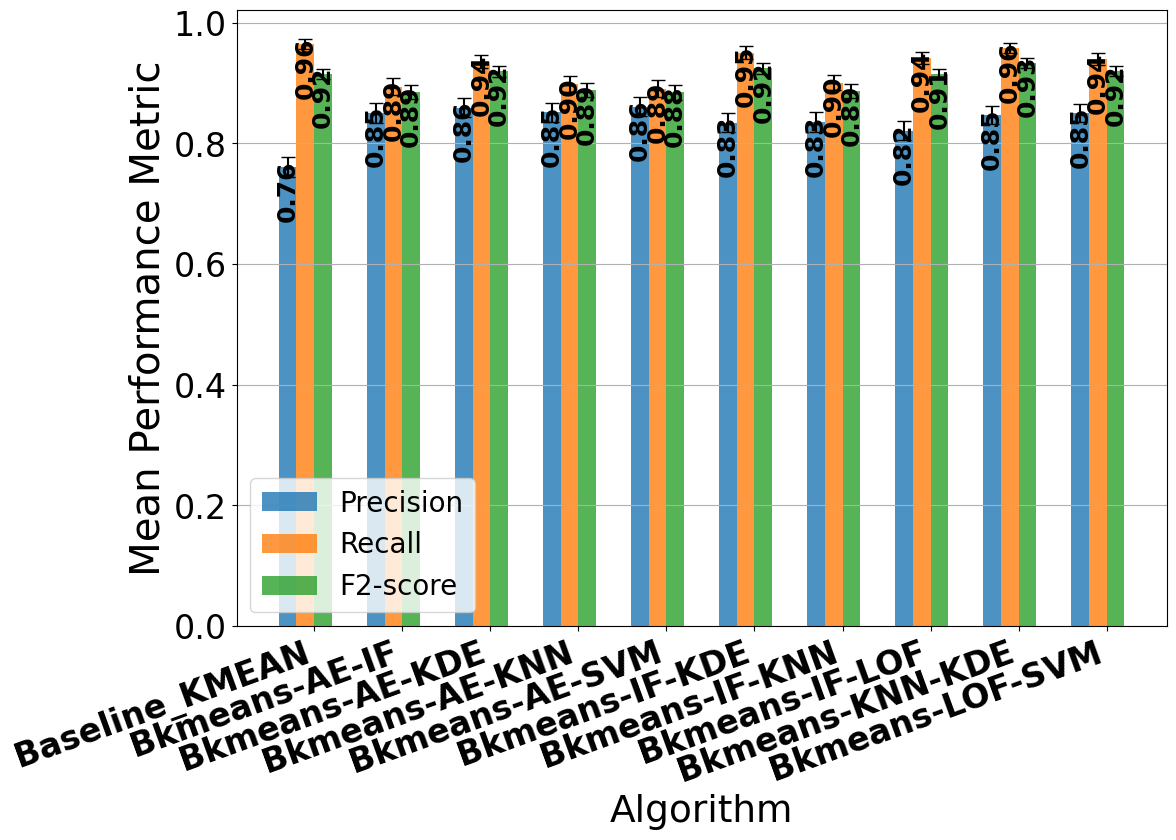

In [26]:
# Compute the mean performance metrics for each algorithm and window
grouped_results = results.groupby(['Algorithm', 'Window']).mean().reset_index()

# Compute the mean performance metrics for each algorithm
algorithm_results = grouped_results.groupby('Algorithm').mean().reset_index()

# Extract the performance metrics and algorithm names
metrics = ['Precision', 'Recall', 'F2-score']
algorithm_names = algorithm_results['Algorithm'].values

# Compute the mean performance metrics and standard errors for each algorithm and metric
algorithm_metric_means = [[algorithm_results[algorithm_results['Algorithm'] == algorithm_name][metric].values[0] for metric in metrics] for algorithm_name in algorithm_names]
algorithm_metric_stds = [[grouped_results[grouped_results['Algorithm'] == algorithm_name][metric].std() for metric in metrics] for algorithm_name in algorithm_names]

# Create a grouped bar plot of the mean performance metrics with error bars
fig, ax = plt.subplots()
bar_width = 0.2
opacity = 0.8
index = np.arange(len(algorithm_names))
for i, metric in enumerate(metrics):
    rects = ax.bar(index + i * bar_width, [means[i] for means in algorithm_metric_means], bar_width, alpha=opacity, yerr=[stds[i] for stds in algorithm_metric_stds], capsize=5, label=metric)
    # Add mean text at the top of each bar
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., height - 0.09, '%.2f' % height, ha='center', va='bottom', fontsize=18, color='black', weight='bold',rotation=90)
ax.set_xlabel('Algorithm', fontsize=27)
ax.set_ylabel('Mean Performance Metric', fontsize=29)
ax.set_xticks(index + (bar_width * 1.5))
ax.set_xticklabels(algorithm_names, fontsize=24, weight = 'bold',rotation=20, ha='right')
ax.legend(fontsize=20)
# Increase the y-tick label font size
ax.tick_params(axis='y', labelsize=24)
ax.grid(axis='y')
plt.show()

In [27]:
results.shape

(1254, 6)

In [28]:
# Save the dataframe to a CSV file
#results.to_csv('results_algorithms_ens.csv', index=False)

In [29]:
grouped_results = results.groupby('Algorithm').agg(
    mean_Precision=('Precision', np.mean),
    std_Precision=('Precision', np.std),
    mean_Recall=('Recall', np.mean),
    std_Recall=('Recall', np.std),
    mean_F1=('F1-score', np.mean),
    std_F1=('F1-score', np.std),
    mean_F2=('F2-score', np.mean),
    std_F2=('F2-score', np.std)
)

# Format the table with mean ± std
formatted_table = grouped_results.apply(
    lambda row: pd.Series({
        'Precision': f'{row["mean_Precision"]:.2f} ± {row["std_Precision"]:.2f}',
        'Recall': f'{row["mean_Recall"]:.2f} ± {row["std_Recall"]:.2f}',
        'F1-score': f'{row["mean_F1"]:.2f} ± {row["std_F1"]:.2f}',
        'F2-score': f'{row["mean_F2"]:.2f} ± {row["std_F2"]:.2f}'
    }),
    axis=1
)

# Generate LaTeX table code
latex_table = formatted_table.to_latex()
print(latex_table)

\begin{tabular}{lllll}
\toprule
{} &    Precision &       Recall &     F1-score &     F2-score \\
Algorithm       &              &              &              &              \\
\midrule
Baseline\_KMEAN  &  0.76 ± 0.02 &  0.96 ± 0.01 &  0.85 ± 0.01 &  0.92 ± 0.01 \\
Bkmeans-AE-IF   &  0.85 ± 0.02 &  0.89 ± 0.01 &  0.87 ± 0.01 &  0.89 ± 0.01 \\
Bkmeans-AE-KDE  &  0.86 ± 0.02 &  0.94 ± 0.01 &  0.90 ± 0.01 &  0.92 ± 0.01 \\
Bkmeans-AE-KNN  &  0.85 ± 0.02 &  0.90 ± 0.01 &  0.87 ± 0.01 &  0.89 ± 0.01 \\
Bkmeans-AE-SVM  &  0.86 ± 0.02 &  0.89 ± 0.01 &  0.88 ± 0.01 &  0.88 ± 0.01 \\
Bkmeans-IF-KDE  &  0.83 ± 0.02 &  0.95 ± 0.01 &  0.89 ± 0.01 &  0.92 ± 0.01 \\
Bkmeans-IF-KNN  &  0.83 ± 0.02 &  0.90 ± 0.01 &  0.87 ± 0.01 &  0.89 ± 0.01 \\
Bkmeans-IF-LOF  &  0.82 ± 0.02 &  0.94 ± 0.01 &  0.88 ± 0.01 &  0.91 ± 0.01 \\
Bkmeans-KNN-KDE &  0.85 ± 0.02 &  0.96 ± 0.01 &  0.90 ± 0.01 &  0.93 ± 0.01 \\
Bkmeans-LOF-SVM &  0.85 ± 0.02 &  0.94 ± 0.01 &  0.89 ± 0.01 &  0.92 ± 0.01 \\
\bottomrule
\end{tabula